Load the modules

In [4]:
import os
import datetime
import netCDF4
import numpy as np
import pprint
import sys
import time
import matplotlib.pyplot as plt
import imageio
import dask
import pysteps

Set the commandline arguments, default argumets and directories

In [8]:
# Commandline
startdate = "202107041600"
startdate = datetime.datetime.strptime(startdate,"%Y%m%d%H%M")
fc_length = 12
nens = 2
ncores = 4

# Defaults
threshold = 0.1
ncascade = 6

# Directories
dir_base = "/home/lesley/KMI/pysteps2024" # change me - this is the dir that contains the hackathon_testdata directory
dir_cascade = os.path.join(dir_base,f'hackathon_testdata/nwp/',startdate.strftime('%Y%m%d'))
dir_motion = dir_cascade
dir_skill = os.path.join(dir_base,'skill')
dir_gif = os.path.join(dir_base,'gifs')
dir_nwc = os.path.join(dir_base,'nwc')
os.makedirs(dir_nwc,exist_ok=True)
os.makedirs(dir_gif,exist_ok=True)

data_src_radar = "rmi"
root_path = os.path.join(dir_base,'hackathon_testdata/radar') #pysteps.rcparams.data_sources[data_src_radar]["root_path"]
path_fmt = f'%Y%m%d' #pysteps.rcparams.data_sources[data_src_radar]["path_fmt"]
fn_pattern = '%Y%m%d%H%M%S.rad.best.comp.rate.qpe' #pysteps.rcparams.data_sources[data_src_radar]["fn_pattern"]
fn_ext = 'hdf' #pysteps.rcparams.data_sources[data_src_radar]["fn_ext"]
importer_name = pysteps.rcparams.data_sources[data_src_radar]["importer"]
importer_kwargs = pysteps.rcparams.data_sources[data_src_radar]["importer_kwargs"]
timestep = pysteps.rcparams.data_sources[data_src_radar]["timestep"]

print("Started nowcast with:")
print(r' Startdate: %s' % startdate.strftime("%Y-%m-%d %H:%M"))
print(r' Forecast length: %i timesteps' % fc_length)
print(r' Number of ensemble members: %i' % nens)
print(r' Number of workers: %i' % ncores)
print(r' Rain/No-rain threshold: %.2f' % threshold)
print(r' Number of cascade levels: %i' % ncascade)
print(r' Motion vectors are loaded from: %s' % dir_motion)
print(r' Cascade decompositions are loaded from: %s' % dir_cascade)
print(r' NWP skill is saved in: %s' % dir_skill)
print(r' Nowcast netCDF file is saved in: %s' % dir_nwc)
print('')

Started nowcast with:
 Startdate: 2021-07-04 16:00
 Forecast length: 12 timesteps
 Number of ensemble members: 2
 Number of workers: 4
 Rain/No-rain threshold: 0.10
 Number of cascade levels: 6
 Motion vectors are loaded from: /home/lesley/KMI/pysteps2024/hackathon_testdata/nwp/20210704
 Cascade decompositions are loaded from: /home/lesley/KMI/pysteps2024/hackathon_testdata/nwp/20210704
 NWP skill is saved in: /home/lesley/KMI/pysteps2024/skill
 Nowcast netCDF file is saved in: /home/lesley/KMI/pysteps2024/nwc


Load and preprocess the radar data

In [9]:
print('Loading and preprocessing radar analysis...')
fn_radar = pysteps.io.find_by_date(
        date = startdate,
        root_path = root_path,
        path_fmt = path_fmt,
        fn_pattern = fn_pattern,
        fn_ext = fn_ext,
        timestep = timestep,
        num_prev_files = 2
)

importer_radar = pysteps.io.get_method(importer_name,"importer")
r_radar, _, metadata_radar = pysteps.io.read_timeseries(
        inputfns = fn_radar,
        importer = importer_radar,
        legacy=False
)

metadata_nwc = metadata_radar.copy()
metadata_nwc['shape'] = r_radar.shape[1:]

# 4. Prepare the radar analyses
converter = pysteps.utils.get_method("mm/h")
r_radar, metadata_radar = converter(r_radar,metadata_radar)

r_radar[r_radar < threshold] = 0.0
metadata_radar["threshold"] = threshold

r_obs = r_radar[-1,:,:].copy()
metadata_obs = metadata_radar.copy()

transformer = pysteps.utils.get_method("dB")
r_radar, metadata_radar = transformer(
        R = r_radar,
        metadata = metadata_radar,
        threshold = threshold,
#        zerovalue=-10.0
)

oflow_method = pysteps.motion.get_method("LK")
v_radar = oflow_method(r_radar)
print('done!')

Loading and preprocessing radar analysis...
done!


Get the available NWP dates, select the closest one and load the velocities and cascade

In [10]:
fcsttimes_nwp = []
for file in os.listdir(dir_motion):
    fcsttimes_nwp.append(
            datetime.datetime.strptime(file.split("_")[2].split('.')[0],'%Y%m%d%H%M%S')
    )

startdate_nwp = startdate + datetime.timedelta(minutes=timestep)
date_nwp = startdate_nwp + max([nwptime - startdate_nwp for nwptime in fcsttimes_nwp if nwptime <= startdate_nwp]) 

model='ao13'
fn_motion = os.path.join(dir_motion,
        r'motion_%s_%s.npy' % (model,date_nwp.strftime('%Y%m%d%H%M%S'))
)
fn_cascade = os.path.join(dir_cascade,
        r'cascade_%s_%s.nc' % (model,date_nwp.strftime('%Y%m%d%H%M%S'))
)

if not os.path.exists(fn_cascade):
    raise Exception('Cascade file %s accompanying motion file %s does not exist' % (fn_cascade,fn_motion))
print(r'Loading NWP cascade and velocities for run started at %s...' % date_nwp.strftime('%Y-%m-%d %H:%M'))
r_decomposed_nwp, v_nwp = pysteps.blending.utils.load_NWP(
        input_nc_path_decomp = fn_cascade,
        input_path_velocities = fn_motion,
        start_time=np.datetime64(startdate_nwp), 
        n_timesteps=fc_length
)

# 5.bis Make sure the NWP cascade and velocity fields have an extra 'n_models' dimension
r_decomposed_nwp = np.stack([r_decomposed_nwp])
v_nwp = np.stack([v_nwp])
print('done!')

Loading NWP cascade and velocities for run started at 2021-07-04 16:05...
done!


Prepare the netCDF exporter-function

In [11]:
def write_netCDF(R):
    R, _ = converter(R, metadata_radar)
    pysteps.io.export_forecast_dataset(R, exporter)

exporter = pysteps.io.initialize_forecast_exporter_netcdf(
        outpath = dir_nwc,
        outfnprefix = 'blended_nowcast_%s' % startdate.strftime("%Y%m%d%H%M"),
        startdate = startdate_nwp,
        timestep = timestep,
        n_timesteps = fc_length,
        shape = metadata_nwc['shape'],
        n_ens_members = nens,
        metadata = metadata_nwc,
        incremental = 'timestep'
)

unknown projection lcc


Start the nowcast

In [12]:
nwc_method = pysteps.blending.get_method("steps")
r_nwc = nwc_method(
        precip = r_radar,
        precip_models = r_decomposed_nwp,
        velocity = v_radar,
        velocity_models = v_nwp,
        timesteps = fc_length,
        timestep = timestep,
        issuetime = startdate,
        n_ens_members = nens,
        n_cascade_levels = ncascade,
        blend_nwp_members = False,
        precip_thr = metadata_radar['threshold'],
        kmperpixel = metadata_radar['xpixelsize']/1000.0,
        extrap_method = 'semilagrangian',
        decomp_method = 'fft',
        bandpass_filter_method = 'gaussian',
        noise_method = 'nonparametric',
        noise_stddev_adj = 'auto',
        ar_order = 2,
        vel_pert_method = None,
        weights_method = 'bps',
        conditional = False,
        probmatching_method = 'cdf',
        mask_method = 'incremental',
        callback = write_netCDF,
        return_output = True,
        seed = 24,
        num_workers = ncores,
        fft_method = 'numpy',
        domain = 'spatial',
        outdir_path_skill = dir_skill,
        extrap_kwargs = None,
        filter_kwargs = None,
        noise_kwargs = None,
        vel_pert_kwargs = None,
        clim_kwargs = None,
        mask_kwargs = None,
        measure_time = False
)

r_nwc, metadata_nwc = transformer(
        R = r_nwc,
        threshold = -10,
        inverse = True
)

pysteps.io.close_forecast_files(exporter)
print("nowcast done!")

STEPS blending

Inputs
------
forecast issue time:         2021-07-04T16:00:00
input dimensions:            700x700
km/pixel:                    1.0
time step:                   5 minutes

NWP and blending inputs
-----------------------
number of (NWP) models:      1
blend (NWP) model members:   False
decompose (NWP) models:      no

Methods
-------
extrapolation:               semilagrangian
bandpass filter:             gaussian
decomposition:               fft
noise generator:             nonparametric
noise adjustment:            yes
velocity perturbator:        None
blending weights method:     bps
conditional statistics:      no
precip. mask method:         incremental
probability matching:        cdf
FFT method:                  numpy
domain:                      spatial

Parameters
----------
number of time steps:        12
ensemble size:               2
parallel threads:            4
number of cascade levels:    6
order of the AR(p) model:    2
precip. intensity threshold: -10.

Plot the results

In [13]:
r_nwc.shape

(2, 12, 700, 700)

In [16]:
from pysteps.visualization import plot_precip_field
from ipywidgets import interactive
from ipywidgets import Layout, interact, IntSlider, FloatSlider
def plotter(t=0,member=0):
    if t==0:
        data = r_obs
    else:
        data = r_nwc[member,t-1,:,:]
    fig = plt.figure(figsize=(10,10))
    plot_precip_field(data,
                      geodata=metadata_obs,
                      colorscale="STEPS-BE",
                      title="Blended nowcast for %s + %i min" % (startdate.strftime('%Y-%m-%d %H:%M'), (t)*5),
                     )
    plt.tight_layout()
    plt.show()
    

interactive(children=(IntSlider(value=0, description='t', max=11), Dropdown(description='member', options=(0, …

In [14]:
def plotter2(t=0):
    fig = plt.figure(figsize=(18,10))
    fig.add_subplot(1,2,1)
    plot_precip_field(r_blend[t,:,:],
                      geodata=meta_output,
                      colorscale="STEPS-BE",
                      title=f"Blended nowcast for {meta_output['timestamps'][-1]} + {t*5} min"
                     )
    fig.add_subplot(1,2,2)
    plot_precip_field(r_nwc[t,:,:],
                      geodata=meta_output,
                      colorscale="STEPS-BE",
                      title=f"Non-blended nowcast for {meta_output['timestamps'][-1]} + {t*5} min"
                     )
    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=0, description='t', max=11), Output()), _dom_classes=('widget-interact',…

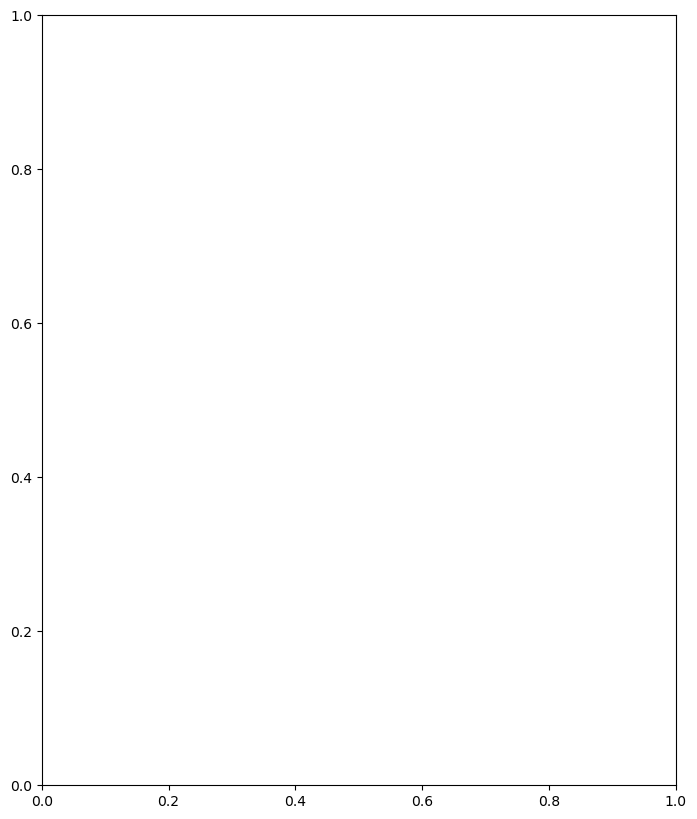